In [ ]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip uninstall -y tensorflow
!pip install tensorflow-gpu==1.14.0
!pip install keras==2.1.0
!pip install h5py==2.10.0
!pip install numpy==1.19.3
!pip install scikit-image==0.16.2

Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 377.1 MB 9.3 kB/s 
     |████████████████████████████████| 3.1 MB 40.3 MB/s 
     |████████████████████████████████| 50 kB 6.9 MB/s 
     |████████████████████████████████| 488 kB 73.9 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.5 MB 1.3 MB/s 
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3


In [ ]:
# pip install mrcnn-colab
#https://github.com/matterport/Mask_RCNN, I downloaded codes  here and modify according to my requirements.

In [ ]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN
ROOT_DIR = '/content/drive/MyDrive/Colab Notebooks/mask_rcnn'

# Import mrcnn libraries
sys.path.append(ROOT_DIR)
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

Using TensorFlow backend.


In [ ]:
class CustomConfig(Config):
    """Configuration for training on the pupil dataset.
    Derives from the base Config class and overrides values specific
    to the pupil dataset.
    """
    # Give the configuration a recognizable name
    NAME = "custom"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 85/IMAGES_PER_GPU
    VALIDATION_STEPS = 50
    
config = CustomConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [ ]:
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")  # This is  pretrained coco model, which we will used to train our model. 
                                                               #Because we have  small data set and we need more data set for better training in deep learning so I will use coco pretrained model with my dataset.
# Log  Directory will have all kinds of logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# New Section

# Define the dataset
I've attempted to make this generic to any COCO-like dataset. That means if you have another dataset defined in the COCO format, it should work.

In [ ]:
#  Preprocessing data ,NOW WE WILL CREATE CUSTOME DATASET FOR OUR WORK
# As we have  cooc like data set, and we have json files ,so we need to process each fields of dataset

#Iris_pupil_coco_like_dataset  class provides a consistent interface for working with Iris pupil dataset. 
#We will create new datasets for Iris pupil  dataset training without changing the model's code.
#load_data_iris_pupil , using this  method, we iterate through all the files in the image and annotations folders to 
# add the class, images and annotations to create the dataset using add_class method.
# Basically , we are iterating through all json objects and creating a cutsome data using add_class method.
class Iris_pupil_coco_like_dataset(utils.Dataset): 
    def load_data_iris_pupil(self, annotation_json, images_dir):  
      # Using this method, we will iterate through all the files in the images, annotatuons folders to add the class, images and annotations to create dataset using add_class method

        # Load json fille 
        iris_pupil_json_file = open(annotation_json)  #
        iris_pupil_coco_json = json.load(iris_pupil_json_file) 
        iris_pupil_json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for iris_pupil_category in iris_pupil_coco_json['categories']:
            iris_pupil_class_id = iris_pupil_category['id']
            iris_pupil_class_name = iris_pupil_category['name']
            if iris_pupil_class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations value from iris pupil coco like dataset
        iris_pupil_annotation = {} # create a empty dictionary
        for iris_pupil_annotation in iris_pupil_coco_json['annotations']:
            iris_pupil_image_id = iris_pupil_annotation['image_id']
            if iris_pupil_image_id not in iris_pupil_annotation:
                iris_pupil_annotation[iris_pupil_image_id] = []
            iris_pupil_annotation[iris_pupil_image_id].append(iris_pupil_annotation)
        
        # Get all kinds of  images  and add them to the irisi pupil  dataset
        iris_pupil_seen_images = {}
        for image in iris_pupil_coco_json['images']:
            image_id = image['id']
            if image_id in iris_pupil_seen_images:
                print("Warning: Skipping duplicate iris or pupil image id: {}".format(image))
            else:
                iris_pupil_seen_images[image_id] = image
                try:
                    iris_pupil_image_file_name = image['file_name']
                    iris_pupil_image_image_width = image['width']
                    iris_pupil_image_image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                iris_pupil_image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                iris_pupil_image_annotations = annotations[image_id]
        
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=iris_pupil_image_path,
                    width=iris_pupil_image_image_width,
                    height=iris_pupil_image_image_height,
                    annotations= iris_pupil_image_annotations
                )


    # Load instance masks for the given image.
    # MaskRCNN expects masks in the form of a bitmap [height, width, instances].
    # Args:image_id: The id of the image to load masks for
    # Returns:masks: A bool array of shape [height, width, instance count] with
    # one mask per instance.
    # class_ids: a 1D array of class IDs of the instance masks.


    def iris_pupil_load_mask(self, image_id):   # This method generates the masks for every object in the image such as mask over iris or pupil. 
                                                 #It will  returns class ids,  one mask per instance, one diemntional array of class id for the instance masks
       
        iris_pupil_image_info = self.image_info[image_id]
        iris_pupil_annotations = iris_pupil_image_info['annotations']
        iris_pupil_instance_masks = []
        iris_pupil_class_ids = []
        
        for iris_pupil_annotation in iris_pupil_annotations:
            class_id = iris_pupil_annotation['category_id']
            mask = Image.new('1', (iris_pupil_image_info['width'], iris_pupil_image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1') # Draw mask 
            for iris_pupil_segmentation in iris_pupil_annotation['segmentation']:
                mask_draw.polygon(iris_pupil_segmentation, fill=1) # 
                iris_pupil_bool_array = np.array(mask) > 0
                iris_pupil_instance_masks.append(iris_pupil_bool_array)
                iris_pupil_class_ids.append(class_id)

        iris_mask = np.dstack(iris_pupil_instance_masks)
        iris_class_ids = np.array(class_ids, dtype=np.int32)
        print(iris_mask)
        
        return iris_mask, iris_class_ids

# Create the Training and Validation Datasets
Make sure you download the training dataset linked at the top of this notebook. If you put the dataset somewhere else, update the paths below.

In [ ]:
# Create Dataset using Iris_pupil_coco_like_dataset, passing train.json file and image folder
iris_pupil_dataset_train = Iris_pupil_coco_like_dataset()
iris_pupil_dataset_train.load_data_iris_pupil('/content/drive/MyDrive/mask_rcnn/pupil_dataset/train.json', 
            '/content/drive/MyDrive/mask_rcnn/pupil_dataset/images')

# Prepare dataset
iris_pupil_dataset_train.prepare() 

iris_pupil_dataset_validation = Iris_pupil_coco_like_dataset()
iris_pupil_dataset_validation.load_data_iris_pupil('/content/drive/MyDrive/mask_rcnn/pupil_dataset/validation.json', 
            '/content/drive/MyDrive/mask_rcnn/pupil_dataset/images')
# Prepare dataset
iris_pupil_dataset_validation.prepare()

/content/drive/MyDrive/Colab Notebooks/mask_rcnn/pupil_dataset/images/case_925_0000013.jpg
[{'id': 137, 'image_id': 105, 'category_id': 1, 'segmentation': [[317.7, 193.5, 325.3, 179.2, 336.2, 167.8, 357.2, 153.9, 368.7, 150.2, 382.8, 148.5, 396.5, 150.8, 412.8, 156.7, 423.7, 162.7, 438.7, 176.1, 444.9, 185.5, 450.9, 196.8, 456.0, 221.5, 456.6, 238.3, 455.3, 244.4, 452.5, 254.4, 442.0, 274.3, 434.3, 284.0, 410.9, 301.3, 384.0, 306.9, 373.2, 307.1, 362.0, 303.5, 354.9, 303.2, 340.0, 292.7, 326.6, 278.7, 316.2, 256.2, 312.2, 238.8, 312.3, 215.4, 317.4, 194.0]], 'area': 17928, 'bbox': [312.0, 149.0, 145.0, 158.0], 'iscrowd': False, 'color': '#6b74da', 'metadata': {}}, {'id': 138, 'image_id': 105, 'category_id': 2, 'segmentation': [[446.2, 123.1, 462.1, 136.0, 476.1, 151.2, 493.9, 181.1, 501.1, 202.8, 502.5, 231.8, 495.8, 271.0, 484.7, 291.9, 472.4, 307.6, 456.5, 323.1, 444.5, 331.0, 432.4, 336.0, 401.0, 338.6, 366.7, 338.9, 345.8, 337.3, 335.1, 333.4, 318.2, 323.9, 302.1, 310.7, 290.2, 295

In [ ]:
# Create model in training mode
# Mask Rnn  Model
# Initialize Mask R-CNN model for training using the Config instance ( Customconfig class)
model = modellib.MaskRCNN(mode="training", config=config,model_dir=MODEL_DIR) # Model_dir=Logs , saving all our model and logs






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
#Loading the Mask R-CNN pre-trained weights from the COCO data set, excluding the last few layers
initialize_with = "coco"  # imagenet, coco, or last

if initialize_with == "coco": # addd pretained coco model weight then we will use our dataset to train the model.
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif initialize_with == "coco":
    model.load_weights(COCO_MODEL_PATH, by_name=True,  # Intialize with COCO , so lets load model weight after model intialization.
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif initialize_with == "last":
    # Load the last model you trained and continue training
    model_path = '/content/drive/MyDrive/mask_rcnn/logs/traffic20220607T1253/mask_rcnn_traffic_0004.h5'
    model.load_weights(model_path, by_name=True)

94658560/94653016 [==============================] - 16s 0us/step


In [ ]:
# Training the dataset with 100 epochs
# Now we have model with loaded weights, So now we can train our model using our dataset.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=250, 
            layers="all")


# Prepare to run Inference
Create a new InferenceConfig, then use it to create a new model.

In [ ]:
class CustomConfig(Config):
    """Configuration for training on the pupil dataset.
    Derives from the base Config class and overrides values specific
    to the pupil dataset.
    """
    # Give the configuration a recognizable name
    NAME = "custom"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 85/IMAGES_PER_GPU
    VALIDATION_STEPS = 5
    
config = CustomConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [ ]:
# Preparing for predictions
class Iris_pupil_model_InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.9 #Load the image that we want to detect the bounding boxes, classes and confidence percentage
    

inference_config = inference_config = Iris_pupil_model_InferenceConfig()

In [ ]:
# Now we are going to detect iris and pupil  in the image with masks and bounding box from the trained model.

#Initialized  the model in the inference mode. 


# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir="")


Instructions for updating:
Use `tf.cast` instead.


In [ ]:
#Load the model's weights from the data set used to train the model.
model_path = '/content/drive/MyDrive/mask_rcnn/logs/custom20220720T2114/mask_rcnn_custom_0100.h5' # Trained model from log folder
model.load_weights(model_path, by_name=True) # loading weights of trained model

In [ ]:

total_gt = np.array([]) 
total_pred = np.array([]) 
mAP_ = [] #mAP list


#compute total_gt, total_pred and mAP for each image in the test dataset
# Compute total ground truth boxes(total_gt) and total predicted boxes(total_pred) and mean average precision for each Image 
#in the test dataset
for image_id in dataset_val.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =modellib.load_image_gt(dataset_val, config, image_id)#, #use_mini_mask=False)
    info = dataset_val.image_info[image_id]

    # Run the model
    results = model.detect([image], verbose=1)
    r = results[0]
    
    #compute gt_tot and pred_tot
    gt, pred = utils.gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
    total_gt = np.append(total_gt, gt)
    total_pred = np.append(total_pred, pred)
    
    #precision_, recall_, AP_ 
    AP_, precision_, recall_, overlap_ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
    #check if the vectors len are equal
    print("the actual length of the ground truth vect is : ", len(total_gt))
    print("the actual length of the predicted vect is : ", len(total_pred))
    
    mAP_.append(AP_)
    print("Average precision of this image : ",AP_)
    print("The actual mean average precision for the whole images", sum(mAP_)/len(mAP_))

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
the actual length of the ground truth vect is :  2
the actual length of the predicted vect is :  2
Average precision of this image :  1.0
The actual mean average precision for the whole images 1.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
the

# Test model

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


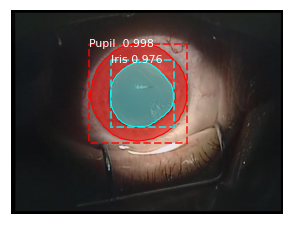

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


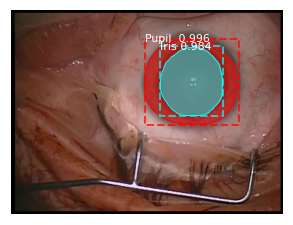

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


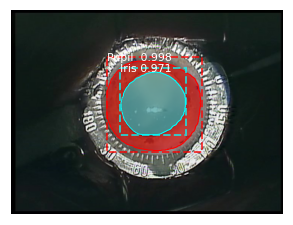

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


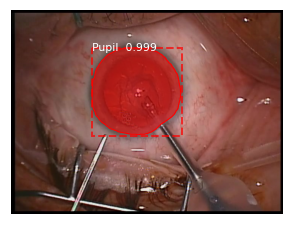

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


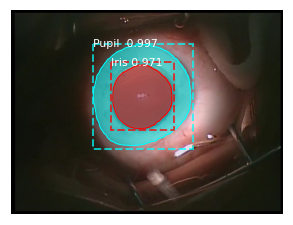

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


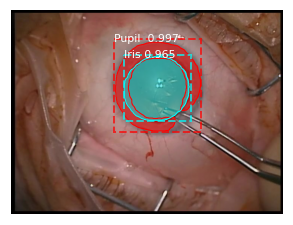

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


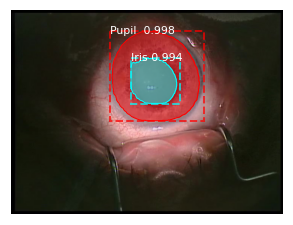

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


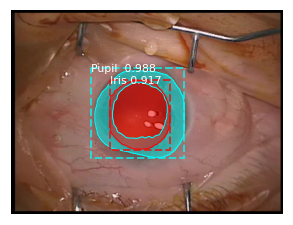

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


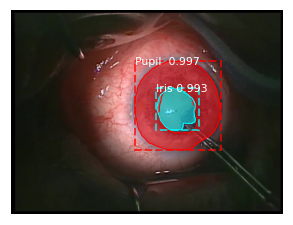

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


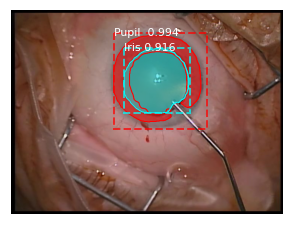

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


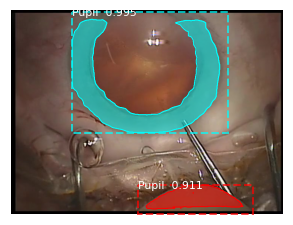

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


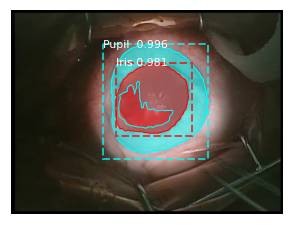

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


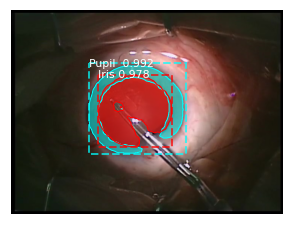

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


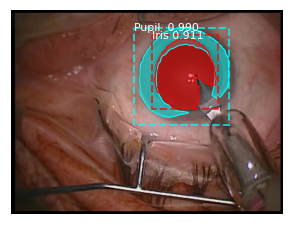

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


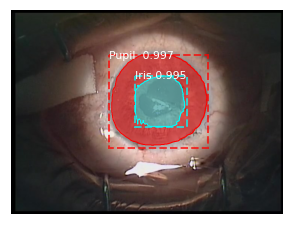

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


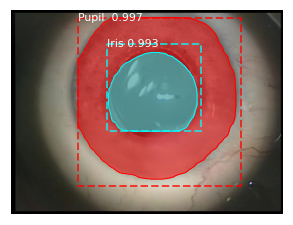

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


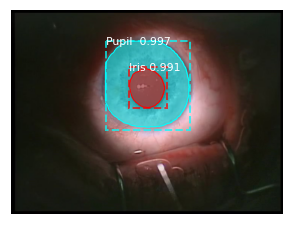

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


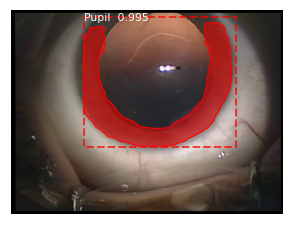

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  142.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


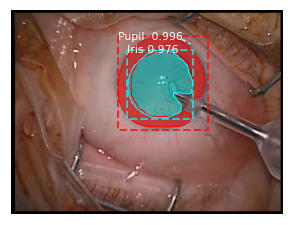

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


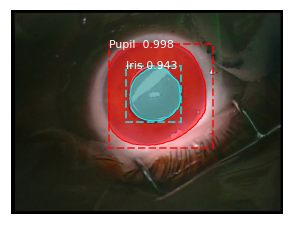

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


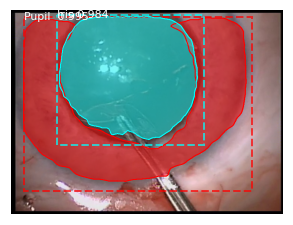

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


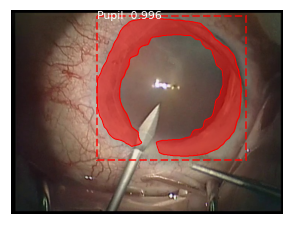

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


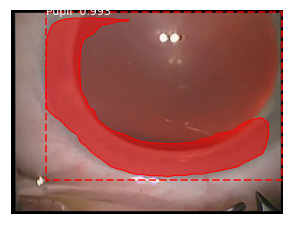

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


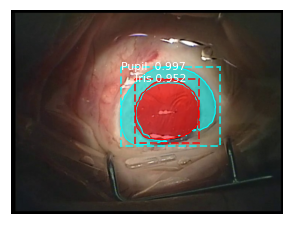

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


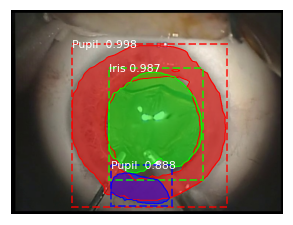

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


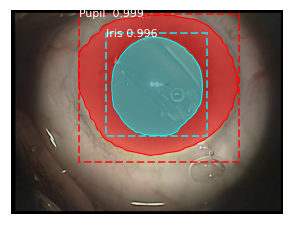

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


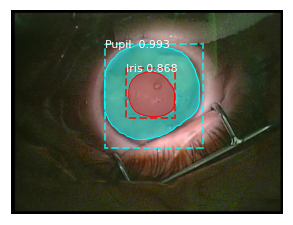

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


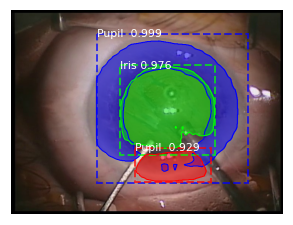

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


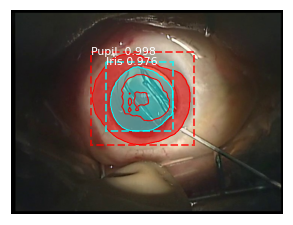

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  140.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


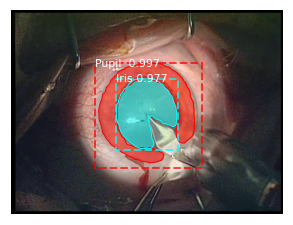

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


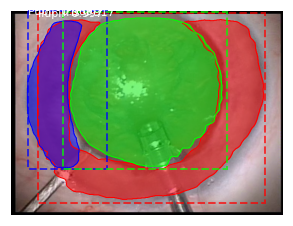

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


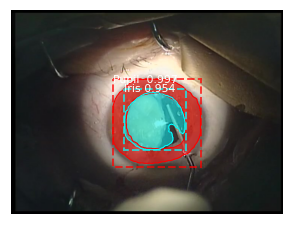

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  144.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


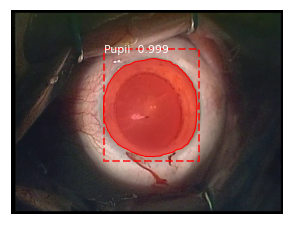

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


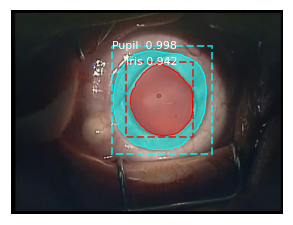

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


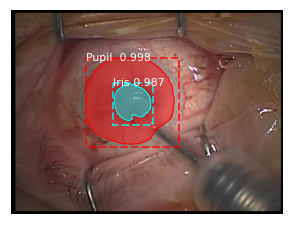

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  144.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


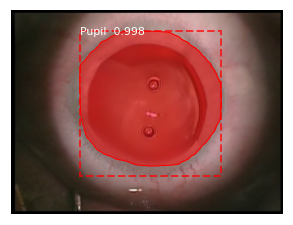

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


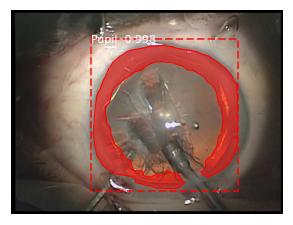

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  132.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


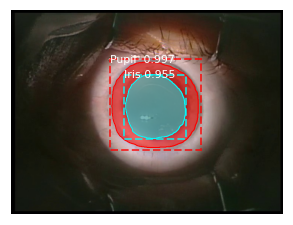

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


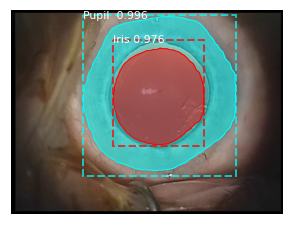

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


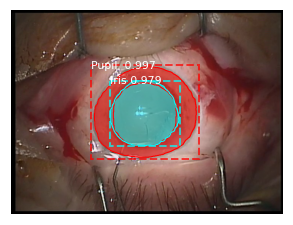

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  137.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


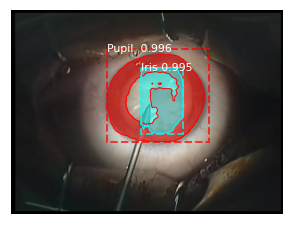

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


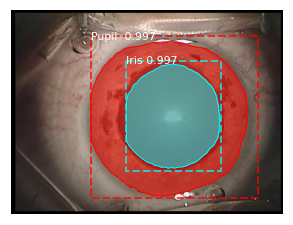

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


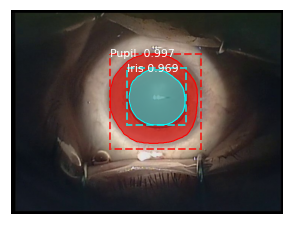

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


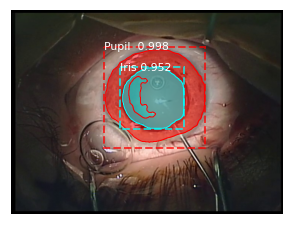

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


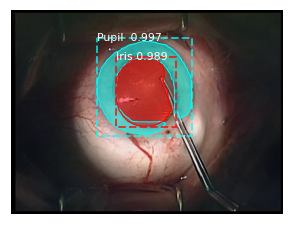

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


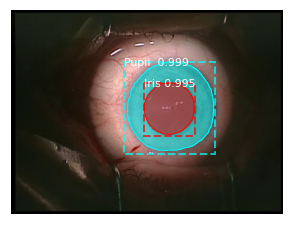

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  142.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


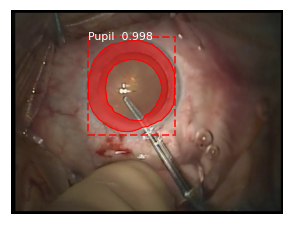

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


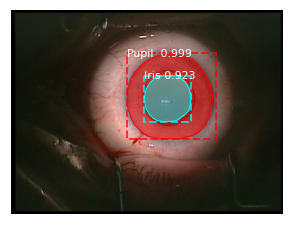

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


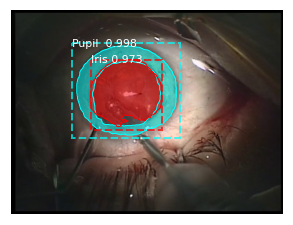

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


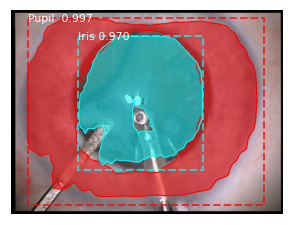

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


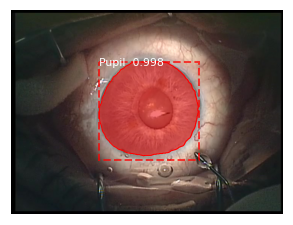

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


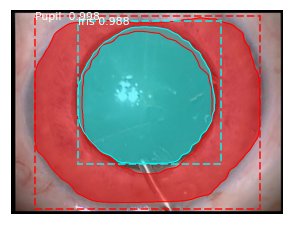

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  136.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


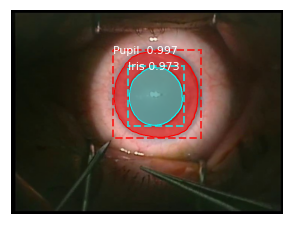

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


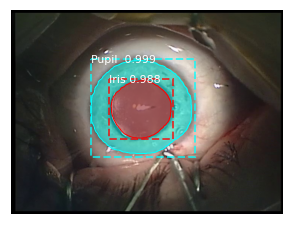

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


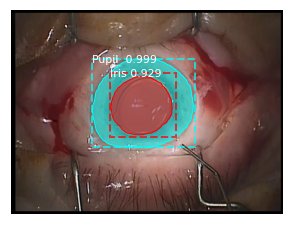

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


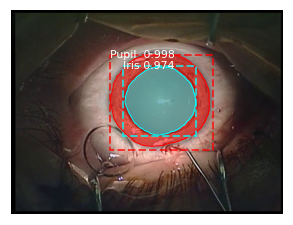

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


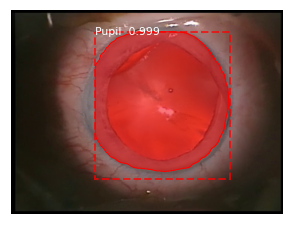

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


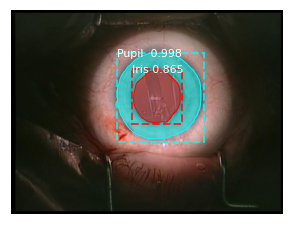

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


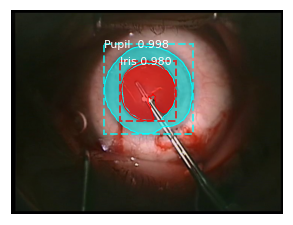

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


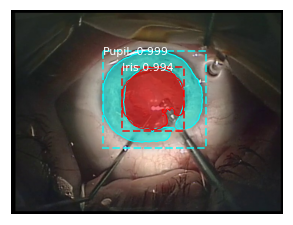

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


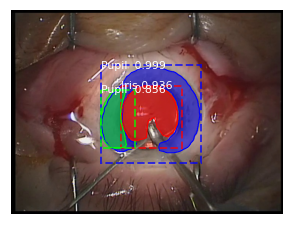

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  136.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


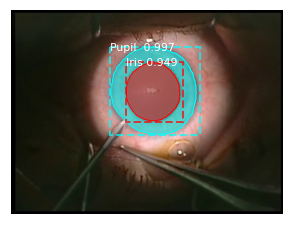

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


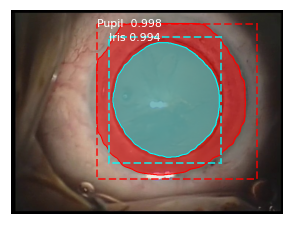

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


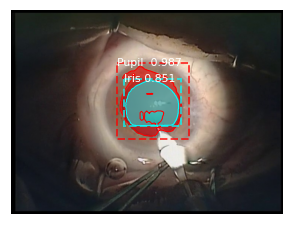

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


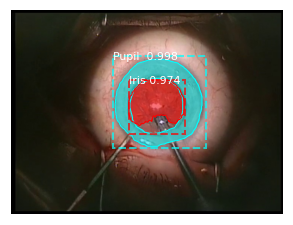

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


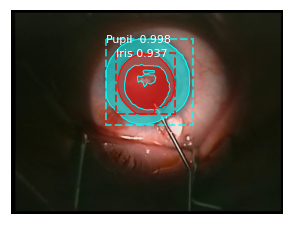

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


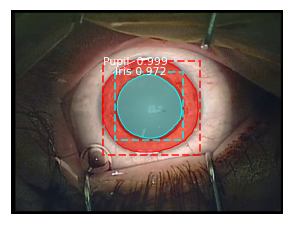

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


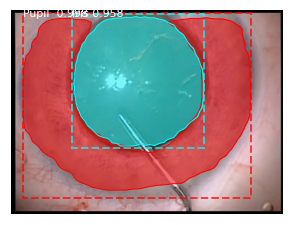

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


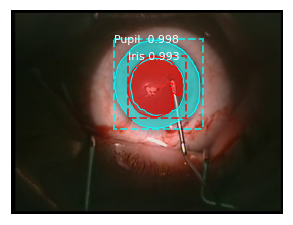

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


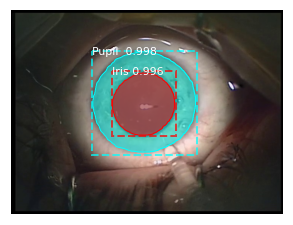

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


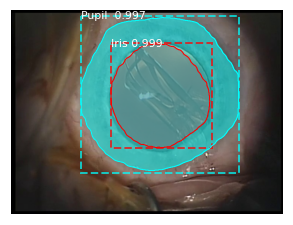

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


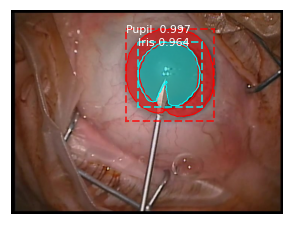

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


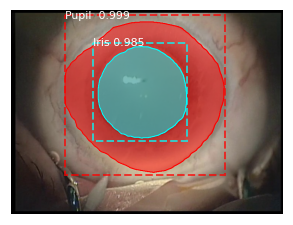

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


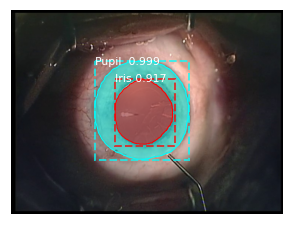

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


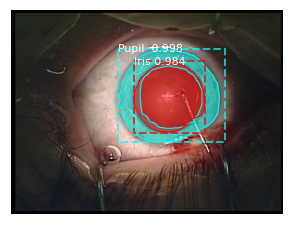

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


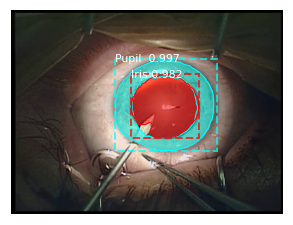

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


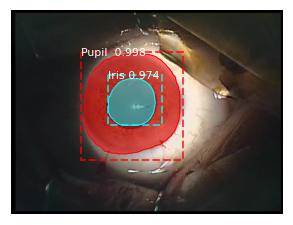

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


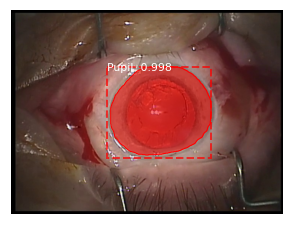

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


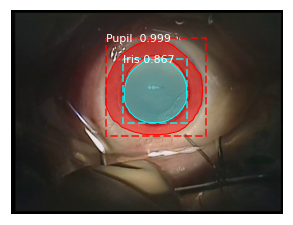

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


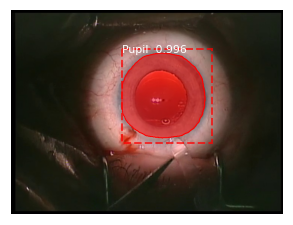

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


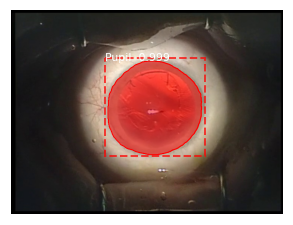

Processing 1 images
image                    shape: (540, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


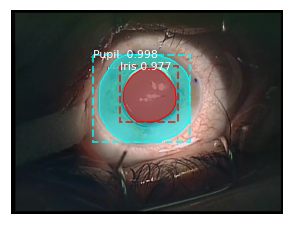

In [ ]:
import skimage

iris_pupil_class_name = ['BG','Iris', 'Pupil '] # BG backgroud, 
iris_pupil_real_test_dir = '/content/drive/MyDrive/mask_rcnn/pupil_dataset/images/'
iris_images_image_paths = []
for Iris_pupil_filename in os.listdir(iris_pupil_real_test_dir):
    if os.path.splitext(Iris_pupil_filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        iris_images_image_paths.append(os.path.join(iris_pupil_real_test_dir, Iris_pupil_filename))

for iris_pupil_img_p in iris_images_image_paths:
    iris_pupil_img = skimage.io.imread(iris_pupil_img_P)
    img_array = np.array(iris_pupil_img)
    results = model.detect([img_array], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], iris_pupil_class_name, r['scores'], figsize=(5,5))

In [ ]:
#https://github.com/matterport/Mask_RCNN
#https://towardsdatascience.com/object-detection-using-mask-r-cnn-on-a-custom-dataset-4f79ab692f6d
#https://www.youtube.com/watch?v=t1MrzuAUdoE&t=9s
#https://ftp.itec.aau.at/datasets/ovid/iris_pupil_seg/index.html
#https://www.immersivelimit.com/tutorials/create-coco-annotations-from-scratch